# GEM Cookbook

This notebook aims to provide an introduction to the usage of the gym-electric-motor (GEM) toolbox. The first section deals with the basic building blocks of GEM.
Further sections provide a step by step guide to customize the different features offered by the toolbox. In this example, a guide to create a customized discrete permanent magnet synchronous motor (PMSM) environment is presented.

## 1.    Overview

The gym-electric-motor (GEM) package is a Python toolbox for the simulation and control of various electric motors.

It is built upon [OpenAI Gym Environments](https://gym.openai.com/), and, therefore, can be used for both, classical control simulation and reinforcement learning experiments. It allows you to construct a typical drive train with the usual building blocks, i.e. supply voltages, converters, electric motors and load models, and obtain not only a closed-loop simulation of this physical structure, but also a rich interface for plugging in any decision making algorithm, from PI-controllers to [Deep Deterministic Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) agents.

### 1.1  Installation
Before you can start, you need to make sure that you have gym-electric-motor installed. You can install it easily using pip:

```
pip install gym-electric-motor
```
    
Alternatively, install the latest developer version directly from GitHub:
https://github.com/upb-lea/gym-electric-motor

For this notebook, we can install it by executing the following cell.

In [1]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git

### 1.2 Building Blocks
A GEM environment consists of following building blocks:
- Physical structure:
   - Supply voltage
   - Converter
   - Electric motor
   - Load model
- Utility functions for reference generation, reward calculation and visualization
 
#### Information Flow in a GEM Environment
![](../../docs/plots/SCML_Overview.png)

The following motor models are included:

Four DC motors:

- permanently excited motor
- externally excited motor
- series motor
- shunt motor

Two three phase motors:

- PMSM (permanent magnet synchronous motor)
- SynRM (synchronous reluctance motor)

Two variants of the induction motor:

- SCIM (squirrel cage induction motor)
- DFIM (doubly fed induction motor)

Following converters are included:

- 1 quadrant converter (1QC)

- 2 quadrant converter (2QC) as an asymmetric half bridge with both current polarities

- 4 quadrant converter (4QC)

- B6 bridge converter (B6C)

All converters can consider interlocking times and a dead time of one sampling interval.
Furthermore, they can be controlled with a discrete action space or a continuous action space.

Discrete actions are the direct switching states of the transistors.
Continuous actions are the duty cycles for a pulse width modulation on the transistors. 

The load model consists of a quadratic load function, with user-defined coefficients. 
Furthermore the moment of inertia of the load attached to the motor can be specified.

The included states for each motor are summarized and briefly described in the [Motor Dashboard](visualizations/motor_dashboard.html).
Every state that can be plotted can also be used in the state filter or as observed state.
The actions are basically understood as the desired duty cycles. The actual applied voltage can be taken from the observations.
The observations are normalized to their physical limits that can be accessed with `env.limits`.
Therefore, all values are typically in a range of [0, 1] or [-1, 1] without limit violation.

All nominal values of voltages and currents are DC values in the case of a DC motor and peak phase values for the PMSM.
Therefore, data sheet values for line voltage and phase currents of a PMSM has to be transformed with:
$U_N = \sqrt{\frac{2}{3}}U_L$, $I_N = \sqrt{2}I_S$.

Moreover, the angular velocity is the mechanical one and not the electrical:
$p\omega_{me} = p\omega = \omega_{el}$

### 1.3 OpenAI Gym Interface
Like every gym environment, the basic user interface consists of four main functions.
* `import gym_electric_motor as gem`    
   Import the package. 

* `env = gem.make(environment-id, **kwargs)`  
    Returns an instantiated motor environment. Call this function at the beginning.
    The `gem.make()` method is equal to the `gym.make()`. By using `gem.make()`you can avoid importing gym additionally. 
 
* `(initial_state, initial_reference) = env.reset()`  
    Resets the motor. This includes a new initial state and new reference trajectories.
    Call this function before a new episode starts. 

* `(state, reference), reward, done, _ = env.step(action)`      
    This function performs one action on the environment for one time step.
    It simulates the motor and needs to be called in every time step.
    First, the voltage applied on the motor due to the converter output is determined and then an ODE solver is used to compute the next state. 
    Eventually, the reward is evaluated and returned together with the next observation and a flag indicating termination.
    Several reward functions are available.

* `env.render()`    
    Update the visualization of the motor states.
    The signals to be displayed may be specified in the constructor-parameters of ```gem.make(**kwargs)```.
    All visualizations are optional and should be disabled for increased computing speed.

Basic Routine:

```py
import gym_electric_motor as gem

if __name__ == '__main__':
    env = gem.make("PMSMDisc-v1")  # instantiate a discretely controlled PMSM
    env.reset()
    for _ in range(1000):
        env.render()  # visualize environment
        (states, references), rewards, done, _ = env.step(env.action_space.sample())  # pick random control actions
    env.close()
```

Comprehensive learning material to RL is [freely available](https://github.com/upb-lea/reinforcement_learning_course_materials).

### 1.4 Environment Ids

* DC motors

    * `'DcExtExCont-v1'`
        Externally excited DC motor with continuous actions.
     
    * `'DcExtExDisc-v1'`
        Externally excited DC motor with discrete actions.
    
    * `'DcPermExCont-v1'`
        Permanently excited DC motor with continuous actions.
    
    * `'DcPermexDisc-v1'`
        Permanently excited DC motor with discrete actions.
    
    * `'DcShuntCont-v1'`
        DC shunt motor with continuous actions.
    
    * `'DcShuntDisc-v1'`
        DC shunt motor with discrete actions.
    
    * `'DcSeriesCont-v1'`
        DC series motor with continuous actions.
    
    * `'DcSeriesDisc-v1'`
        DC series motor with discrete actions.
        
* Synchronous motors
    
    * `'PMSMCont-v1'`:  
        Permanent magnet synchronous motor with continuous actions.
    
    * `'PMSMDisc-v1'`:  
        Permanent magnet synchronous motor with discrete actions.
        
    * `'SynRMCont-v1'`:  
        Synchronous reluctance motor with continuous actions.
    
    * `'SynRMDisc-v1'`:  
        Synchronous reluctance motor with discrete actions.
        
* Induction motors

    * `'SCIMCont-v1'`:  
        Squirrel cage induction motor with continuous actions.
        
    * `'SCIMDisc-v1'`:  
        Squirrel cage induction motor with discrete actions.
        
    * `'DFIMCont-v1'`:  
        Doubly fed induction motor with continuous actions.
        
    * `'DFIMDisc-v1'`:  
        Doubly fed induction motor with discrete actions.



### 1.5 Make keyword arguments
Using the keyword arguments in the `gem.make(id, **kwargs)` function you can select different function modules for the 
environment and parametrize these modules. 
The main level modules of each GEM-environment consists of five function modules:

* Physical system
    * keyword: `physical_system`
    * Specification and simulation of the system model.
* Reference generator
    * keyword: `reference_generator`
    * Generation of references that the physical system has to follow.
* Reward function
    * keyword: `reward_function`
    * Reward calculation based on the current state and reference.
* Visualization    
    * keyword: `visualization`
    * Visualization of the physical systems state, reference and rewards.
* State filter
    * keyword: `state_filter`
    * Selection of states that shall be shown to the agent.
    
These function modules can be selected in three ways:

* Passing a keystring (and further keyword arguments for the class) :
     * `reference_generator='SinusoidalReference', amplitude_range=(0.2, 0.8)`

* Passing a class pointer (and further keyword arguments for the class)
    * `reference_generator=SinusoidalReferenceGenerator, amplitude_range=(0.2,0.8)`

* Passing an instantiated object
  * `reference_generator = SinusoidalReferenceGenerator(amplitude_range=(0.2,0.8)`
      
Furthermore, the internal function modules of the physical systems like the converter, motor, or load can be selected in
the make keyword-arguments in the same way. 

The available modules and specific keyword-arguments for each module can be looked up in the [API documentation](https://upb-lea.github.io/gym-electric-motor/parts/environments/environment.html).

## 2. Customize a PMSM Environment

### 2.1 Basic PMSM environment
The following cell provides a method to create a basic motor environment. 
By simply calling the ```gem.make()``` function with the motor environment ID of the required electric motor, one can create a basic motor environment with default parameters and settings for all the relevant sub-components.

With the environment ID you select a certain motor type and action type (continuous or discrete) and with the further 
constructor arguments you can parametrize the environment to your control problem.

In [1]:
import gym_electric_motor as gem

basic_env = gem.make("PMSMDisc-v1")  # pass a motor environment ID 
basic_env

C:\Users\arnet\anaconda3\envs\gem_dev\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 2.2  Physical System
Each system consists of a voltage supply, a power electronic converter, an electrical motor, and the mechanical load (SCML) as shown in the above figure. Each such SCML-system is simulated by a user-defined ODE solver.

#### Voltage Supply

The voltage supply module provides both, DC and AC voltage supplies. 
- The DC supplies are either ideal or non-ideal voltage sources.
- The AC supplies are either ideal single phase or ideal three-phase AC sources.

More documentation regarding the voltage supplies of GEM can be found [here](https://upb-lea.github.io/gym-electric-motor/parts/physical_systems/voltage_supplies/voltage_supply.html). 
For the PMSM environment example, a non-ideal DC voltage supply is created. 
Here, the DC-link is modeled as an RC-circuit loaded from an ideal DC voltage source. 

The non-ideal DC supply in GEM is named 'RCVoltageSupply' and the supply_parameter(dict) consists of resistance R in ohm and capacitance C in farad


In [2]:
supply = 'RCVoltageSupply'
supply_parameter=dict(R=10, C=4e-3)  # Note, R and C values here are not realistic.

#### Converter 
The converters are divided into two classes: The continuously controlled and the discretely controlled converters.

In the continuous case, the agent's actions denote a duty cycle that is modulated to the converter's output voltage.

In the discrete case, the agent's actions denote switching states of the converter at the given instant.
Here, only a discrete amount of options are available. In this notebook, for the PMSM the discrete B6 bridge converter with six switches is utilized per default. This converter provides a total of eight possible actions.


![](../../docs/plots/B6.svg)


#### Motor 
In this tutorial, the electric motor used is the **permanent magnet synchronous motor**.
The motor schematic is the following:


![](../../docs/plots/ESBdq.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

<!-- $\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
 -->

   $ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
    $\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
   $\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>
   



The motor environment ID for the discrete PMSM motor is **"PMSMDisc-v1"**.
The parameters of the specific motor are to be passed by the user as a motor parameter dictionary.
Default parameters will be considered in case the motor parameters are not provided by the user. 
The nominal and limit values which define the operating region of the motor are also passed as a dictionary.

In [3]:
import numpy as np

motor_env_id = "PMSMDisc-v1"
tau = 1e-5    # The duration of each sampling step

# motor type: Brusa HSM16.17.12-C01
motor_parameter = dict(p=3,  # [p] = 1, nb of pole pairs
                       r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
                       l_d=0.37e-3,  # [l_d] = H, d-axis inductance
                       l_q=1.2e-3,  # [l_q] = H, q-axis inductance
                       psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
                       )  

nominal_values=dict(omega=4000*2*np.pi/60,  # angular velocity in rpm
                    i=230,                  # motor current in amps
                    u=350                   # nominal voltage in volts
                    )
# limit values are taken exemplarily as 1.3 times the nominal values
limit_values = {key: 1.5 * nomin for key, nomin in nominal_values.items()}


#### Motor State Initializer
By default, the motor states (e.g. motor currents, rotational speed) are always set to zero whenever the motor environment is reset. In order to generate diverse expisodes, the motor state initializer can be used to draw the initial state values from a given probability distribution within the nominal operating range of the given motor. 

The 'motor_initializer' is a dictionary that consists of the type of distribution, for example, uniform or gaussian distribution and the interval of values within the nominal operating region. 
Here, the motor states, i.e. $i_{sd}$, $i_{sq}$ and motor angle are initialized with values sampled from a uniform distribution from the provided intervals.

$i_{sd}$ and $i_{sq}$ are the motor currents in the [d-q coordinate system](https://en.wikipedia.org/wiki/Direct-quadrature-zero_transformation#:~:text=The%20direct%2Dquadrature%2Dzero%20,an%20effort%20to%20simplify%20analysis).


In [4]:
motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}  

#### Mechanical Load
The mechanical load module in GEM models various external mechanical systems that apply counterforces on the electrical motor's rotor through the drive shaft.
Different types of load models such as constant speed load and polynomial static load are provided. More information can be found in the [documentation.](https://upb-lea.github.io/gym-electric-motor/parts/physical_systems/mechanical_loads/mechanical_load.html)

In this example, the load type: _ConstSpeedLoad_ is used. 
This initializes the load with a constant speed at the start of each episode. 
The initialization value for speed is sampled from a uniform distribution defined by the given interval.

In [5]:
from gym_electric_motor.physical_systems import ConstantSpeedLoad

load = 'ConstSpeedLoad'
load_initializer={'random_init': 'uniform', 'interval':[100,200] }   


### 2.3 Reward Function
The reward calculation is based on the current state and reference of the motor environment. It is calculated as a weighted sum of errors with a certain power as follows:

<!-- <h3 align="center"> -->
<!-- $ reward = - reward\_weights * (abs(state - reference)/ state\_length)^{reward\_power}$   -->

$ r_t = - \sum \limits_{k=0} ^{N} w_{\{k\}}\big | s_{\{k\}t} - s^*_{\{k\}t} \big |^p $   <br> <br>

Here, $r_t$ is the reward at time $t$.  $ w_{\{k\}}$ is the reward weight for the k'th state variable of the $N$ referenced states . $s_{\{k\}t}$ is the k'th state variable of the motor and $s^*_{\{k\}t}$ is the corresponding k'th reference variable at time $t$. The reward power is $p$.


If states are to be monitored for a constraint violation, an additional terminal reward is added. This value depends on the discount factor $\gamma$ as follows. 
<!-- <h3 align="center"> -->
$r_t = -1 / (1 - \gamma).$

In [6]:
gamma = 0.99  #Discount factor for the reward punishment. Should equal agents' discount factor gamma.

rf = gem.reward_functions.WeightedSumOfErrors(  # The function that computes the reward
                reward_weights={'i_sq': 10, 'i_sd': 10}, # Reward weight for each of the systems states.
                gamma=gamma,     # Factor for the reward punishment. Should equal agent's discount factor gamma.
                reward_power=1)# Reward power for each of the systems states

### 2.4 Constraint Monitor
The constraint monitor monitors the system states and assesses whether they violate system boundaries specified by the constraints.

The constraints can be selected from a predefined set within GEM or defined by the user.

The following constraint is used for the motor currents:

$ i_{sd}^2 + i_{sq}^2 > i_{max}^2 $  

Here, $i_{sd}$ and $i_{sq}$ are the motor currents in the d-q coordinate system that can be accessed from the motor states and $i_{max}$ is the maximum allowable current value. This constraint can be directly accessed from the toolbox.

Additionally, a user-defined constraint is put on the $i_{sd}$ current. It is not allowed to go too far into the positive direction. This is modeled as a soft constraint, that already punishes the reward, when $i_{sd}$ gets into the positive range and terminates it completely if it reaches half of $i_{max}$. 

(Remember: The quantities are normalized by their limit values to stay in a range of [-1,1] in the gem-environments.)

In [41]:
SquaredConstraint = gem.constraints.SquaredConstraint

class MyConstraint(gem.constraints.Constraint):
    
    i_sd_idx = 0
    
    def set_env(self, env):
        self.i_sd_idx = env.physical_system.state_positions['i_sd']
        
    def __call__(self, state):
        """This function returns a "violation degree" within [0,1].
        
        This exemplary constraint returns 0 if i_sd is 0 or below.
        It returns a value between 0 and 1 if i_sd is at most half of the generally allowed current limit.
        If i_sd exceeds 0.5 of the current limit, the violation degree is 1.0 and the episode will be terminated.
        
        The violation degree between 0 and 1 directly affects the reward, but does not end an episode.
        It models an "undesired behavior" the agent shall learn to avoid.
        """
        i_sd = state[self.i_sd_idx]
        return 2 * min(max(i_sd, 0), 0.5)
    
def my_constraint_function(state):
    """This function demonstrates how a simple function can be used as a constraint. 
    
    When no information has to be read from the environment to configure the constraint 
    (e.g. for a mapping of state names to their position in the state array), also only a function or any kind
    of callable is sufficient that takes the state as input and returns a float within [0.0, 1.0].
    
    In this example, the index of the torque, that is monitored to go not too far into the negative direction, is known
    a priori by the user. So, the "set_env"-function call is not necessary.
    """
    
    TORQUE_IDX = 1
    return float(state[TORQUE_IDX] < -0.7)

constraints = (SquaredConstraint(('i_sd', 'i_sq')), MyConstraint(), 'omega', my_constraint_function)

### 2.5 Reference Generator
The reference generator produces reference trajectories for the observed states, that the physical system is expected to follow. 
The GEM toolbox provides various reference generators, which can be found in the [documentation.](https://upb-lea.github.io/gym-electric-motor/parts/reference_generators/reference_generator.html)

In this example, references to the motor currents $i_{sq}$ and $i_{sd}$ are considered.
The "WienerProcessReferenceGenerator" is used to generate random references for both $i_{sq}$ and $i_{sd}$. 

The [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) is a stochastic process $W(t)$ for $t>=0$ with $W(0)=0$ such that the increment $W(t)-W(s)$ is Gaussian with mean $0$ and variance $\sigma$ for any $0<=s<t$, while increments for successive time steps are statistically independent.

The individual sub-reference generators are then combined using the "MultipleReferenceGenerator".

In [42]:
from gym_electric_motor.reference_generators import \
    MultipleReferenceGenerator,\
    WienerProcessReferenceGenerator

q_generator = WienerProcessReferenceGenerator(reference_state='i_sq') # sub-reference generator for i_sq
d_generator = WienerProcessReferenceGenerator(reference_state='i_sd') # sub-reference generator for i_sd
rg = MultipleReferenceGenerator([q_generator, d_generator])           # combine the sub-reference generators

### 2.6 Visualization
The visualization module provides an interface to observe and inspect the physical system's states, references, rewards, etc. 
GEM offers two forms of visualization:
- Motor dashboard: A graphical interface which provides visualization in the form of plots.
- Console printer: A simpler interface in the form of console print-outs.

This example demonstrates the usage of the motor dashboard for visualization.
A list of variables to be plotted is passed to the MotorDashboard during initialization. The variables that can be plotted for a given motor environment can be found in the [documentation.](https://upb-lea.github.io/gym-electric-motor/parts/visualizations/motor_dashboard.html)

In [43]:
from gym_electric_motor.visualization import MotorDashboard

visualization = MotorDashboard(state_plots=['i_sq', 'i_sd'], plot_reward=True) 
# plots the states i_sd and i_sq and reward.

### 2.7 Callbacks
GEM callbacks provide an easy-to-use interface to apply hooks on the motor environment during run time. 
Callbacks can be used to get a view of the internal states, collect statistics, or modify certain motor parameters during runtime. 

GEM callbacks can be used to interact with the motor environment:
- At the start/end of every step
- At the start/end of every reset
- At the start of a close() call
    
The following example provides a sample user defined callback implementation. 
The user defined callback object must be a sub-class of the 'Callback' class as shown. 
The objective of the user defined 'RewardLogger' callback object is to create a log of the experiment's mean episode rewards.

Some of the interfaces implemented here are:
- \__init()\__     : A suitable class constructor.
- on_step_end()    : A suitable task to be performed at the end of every step.
- on_reset_begin() : A suitable task at the beginning of each episode.
- on_close         : A suitable task at the beginning of a close.

For the list of all the interfaces, check out the GEM API documentation.    


In [44]:
from gym_electric_motor.core import Callback
from pathlib import Path

class RewardLogger(Callback):
    """Logs the reward accumulated in each episode"""
    def __init__(self):
        self._step_rewards = []
        self._mean_episode_rewards = []
        self.fpath = Path.cwd() /"rl_frameworks" / "saved_agents"
        self.fpath.mkdir(parents=True, exist_ok=True)
        
    def on_step_end(self, k, state, reference, reward, dine):
        """Stores the received reward at each step"""
        self._step_rewards.append(reward)
    
    def on_reset_begin(self):
        """Stores the mean reward received in every episode"""
        self._mean_episode_rewards.append(np.mean(self._step_rewards))
        self._step_rewards = []
        
    def on_close(self):
        """Writes the mean episode reward of the experiment to a file."""
        np.save(self.fpath / "EpisodeRewards.npy", np.array(self._mean_episode_rewards))
        
my_callback = [RewardLogger()]  # instantiate the callback object 

### 2.8 GEM Make Call

The make function takes the environment-ids and several constructor arguments. Every environment also works without further parameters with default values. These default parameters can be looked up in the [API-documentation](https://upb-lea.github.io/gym-electric-motor/index.html) of every GEM-environment.

The various components of the motor environment defined above are passed as arguements to the ```gem.make()``` function. This further returns the discrete PMSM motor environment.

The motor environment can then be passed to a reinforcement learning agent in order to learn a controller.

In [45]:
# define a PMSM with discrete action space
env = gem.make(  
    motor_env_id,
    # visualize the results
    visualization=visualization,
    # parameterize the PMSM and update limitations
    motor_parameter=motor_parameter,
    limit_values=limit_values, nominal_values=nominal_values,
    # define the random initialisation for load and motor
    load=load,
    load_initializer=load_initializer,
    motor_initializer=motor_initializer,
    reward_function=rf,
    tau=tau,
    supply = supply,
    supply_parameter=supply_parameter,
    reference_generator=rg,
    ode_solver='euler',
    callbacks=my_callback,
    constraints=constraints
)

<IPython.core.display.Javascript object>


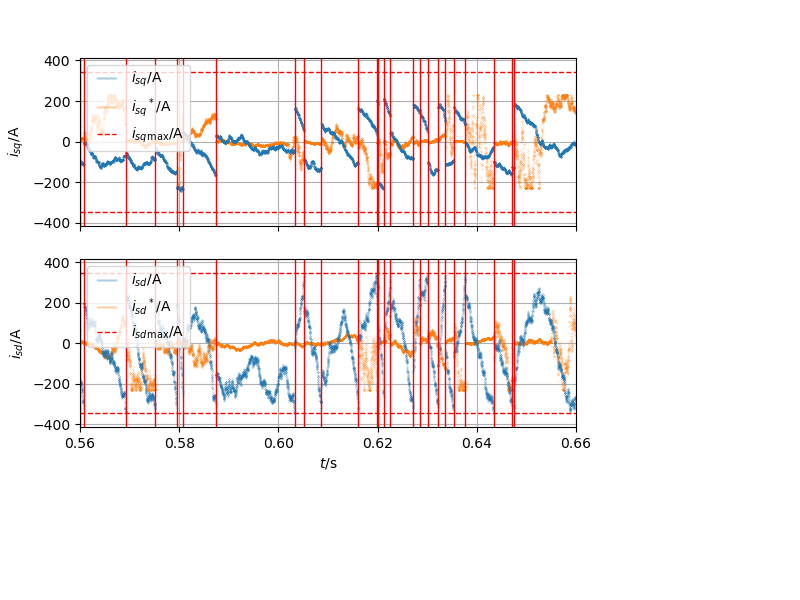

KeyboardInterrupt: 

In [46]:
%matplotlib notebook

# simple routine with random actions applied
env.reset()
k = 0
for i in range(int(8e4)):    
    env.render()  # visualize environment
    (states, refs), rewards, done, _ = env.step(env.action_space.sample())  # pick random control actions
    if done:
        env.reset()
env.close()

You will see a lot of red vertical lines indicating episode terminations. A termination is induced most of the time when limits are violated. This happens in this example very often as we apply random voltages.